In [17]:
# 모듈 생성
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def output_keypoints(frame, proto_file, weights_file, threshold, model_name, BODY_PARTS):
    global points

    # 네트워크 불러오기
    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    # 입력 이미지의 사이즈 정의
    image_height = 368
    image_width = 368

    # 네트워크에 넣기 위한 전처리
    input_blob = cv2.dnn.blobFromImage(frame, 1.0 / 255, (image_width, image_height), (0, 0, 0), swapRB=False, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(input_blob)

    # 결과 받아오기
    out = net.forward()
    out_height = out.shape[2]
    # The fourth dimension is the width of the output map.
    out_width = out.shape[3]

    # 원본 이미지의 높이, 너비를 받아오기
    frame_height, frame_width = frame.shape[:2]

    # 포인트 리스트 초기화
    points = []

    print("<{} Model>".format(model_name))
    for i in range(len(BODY_PARTS)):

        # 신체 부위의 confidence map
        prob_map = out[0, i, :, :]

        # 최소값, 최대값, 최소값 위치, 최대값 위치
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        # 원본 이미지에 맞게 포인트 위치 조정
        x = (frame_width * point[0]) / out_width
        x = int(x)
        y = (frame_height * point[1]) / out_height
        y = int(y)

        if prob > threshold:  # [pointed]
            cv2.circle(frame, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1, lineType=cv2.LINE_AA)
            points.append((x, y))

        else:  # [not pointed]
            cv2.circle(frame, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, lineType=cv2.LINE_AA)
            points.append(None)

    # plt.figure(figsize=(10, 24))
    # plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    # plt.show()
    return frame

In [25]:
def output_keypoints_with_lines(frame, POSE_PAIRS):
    print()
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)
        if points[part_a] and points[part_b]:
            cv2.line(frame, points[part_a], points[part_b], (0, 255, 0), 3)
    plt.figure(figsize=(10, 24))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    plt.show()

<MPII Model>



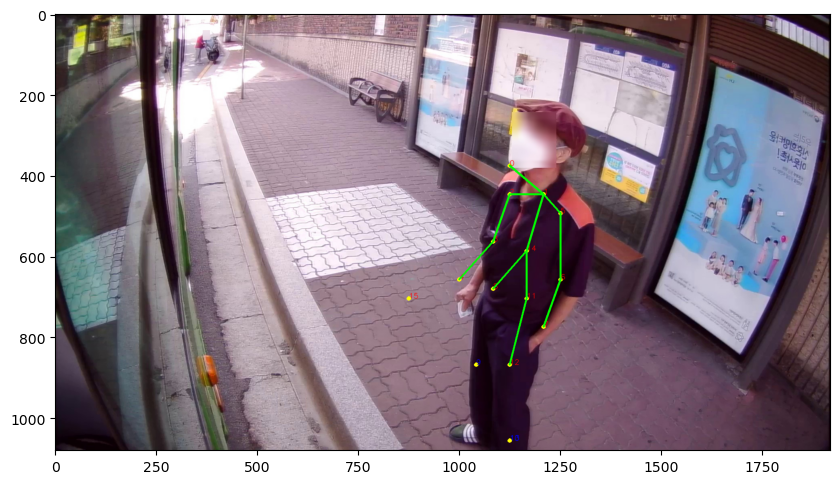

<COCO Model>



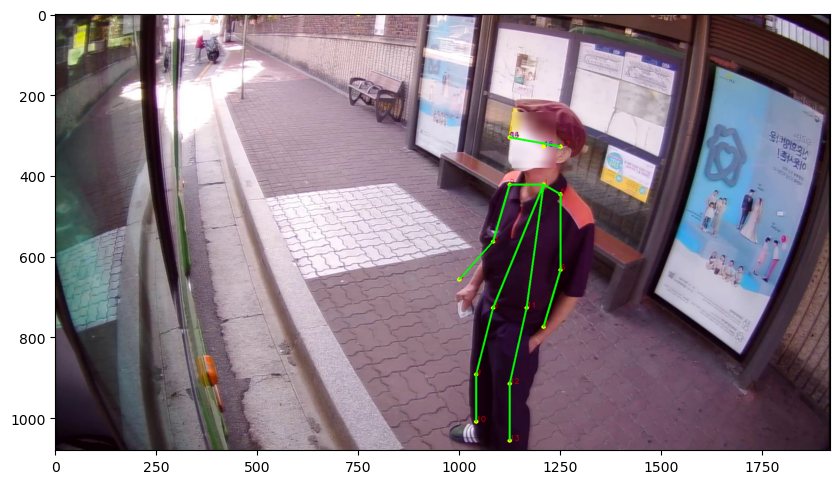

<MPII Model>



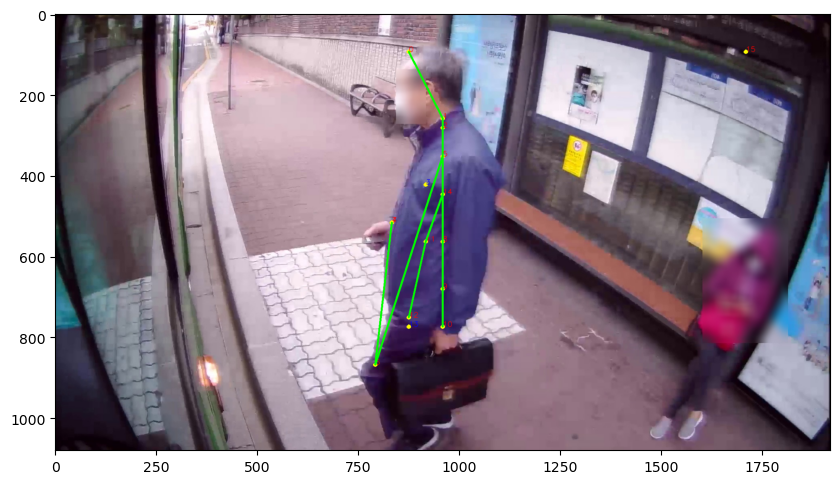

<COCO Model>



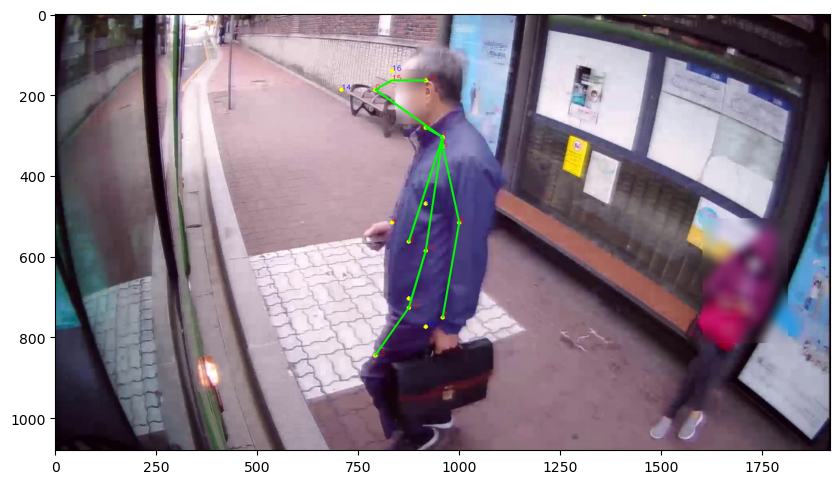

In [27]:
BODY_PARTS_MPI = {0: "Head", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                  5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                  10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "Chest",
                  15: "Background"}

POSE_PAIRS_MPI = [[0, 1], [1, 2], [1, 5], [1, 14], [2, 3], [3, 4], [5, 6],
                  [6, 7], [8, 9], [9, 10], [11, 12], [12, 13], [14, 8], [14, 11]]

BODY_PARTS_COCO = {0: "Nose", 1: "Neck", 2: "RShoulder", 3: "RElbow", 4: "RWrist",
                   5: "LShoulder", 6: "LElbow", 7: "LWrist", 8: "RHip", 9: "RKnee",
                   10: "RAnkle", 11: "LHip", 12: "LKnee", 13: "LAnkle", 14: "REye",
                   15: "LEye", 16: "REar", 17: "LEar", 18: "Background"}

POSE_PAIRS_COCO = [[0, 1], [0, 14], [0, 15], [1, 2], [1, 5], [1, 8], [1, 11], [2, 3], [3, 4],
                   [5, 6], [6, 7], [8, 9], [9, 10], [12, 13], [11, 12], [14, 16], [15, 17]]


# 신경 네트워크의 구조를 지정하는 prototxt 파일 (다양한 계층이 배열되는 방법 등)
protoFile_mpi = "mpii/pose_deploy_linevec.prototxt"
protoFile_mpi_faster = "mpii/pose_deploy_linevec_faster_4_stages.prototxt"
protoFile_coco = "coco/pose_deploy_linevec.prototxt"

# 훈련된 모델의 weight 를 저장하는 caffemodel 파일
weightsFile_mpi = "mpii/pose_iter_160000.caffemodel"
weightsFile_coco = "coco/pose_iter_440000.caffemodel"

# 이미지 경로
files = ["[apt]attend_008A_30.jpg", "[apt]attend_023A_144.jpg"]

# 키포인트를 저장할 빈 리스트
points = []

for file in files: 
    # 이미지 읽어오기
    frame_mpi = cv2.imread(file)
    frame_coco = frame_mpi.copy()
    frame_body_25 = frame_mpi.copy()

    # MPI Model
    frame_MPI = output_keypoints(frame=frame_mpi, proto_file=protoFile_mpi_faster, weights_file=weightsFile_mpi,
                                threshold=0.2, model_name="MPI", BODY_PARTS=BODY_PARTS_MPI)
    output_keypoints_with_lines(frame=frame_MPI, POSE_PAIRS=POSE_PAIRS_MPI)

    # COCO Model
    frame_COCO = output_keypoints(frame=frame_coco, proto_file=protoFile_coco, weights_file=weightsFile_coco,
                                threshold=0.2, model_name="COCO", BODY_PARTS=BODY_PARTS_COCO)
    output_keypoints_with_lines(frame=frame_COCO, POSE_PAIRS=POSE_PAIRS_COCO)